In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
import joblib
warnings.filterwarnings('ignore')

In [39]:
# load the models
linear_model = joblib.load('models/ols_model.pkl')
rf_model = joblib.load('models/rf_model.pkl')
ridge_model = joblib.load('models/ridge_model.pkl')
lasso_model = joblib.load('models/lasso_model.pkl')

In [40]:
df = pd.read_csv('data/merged_climate_iom_data.csv')

In [41]:
country_column = 'country_name'

In [42]:
# Display unique countries in alphabetical order
countries = df[country_column].unique()
print(f"\nFound {len(countries)} unique countries/regions in the dataset")
print(f"Sample countries: {', '.join(countries[:8])}")
# list countries in alphabetical order
print(f"\nCountries in alphabetical order: {', '.join(sorted(countries))}")


Found 50 unique countries/regions in the dataset
Sample countries: Haiti, Sudan, Pakistan, Philippines (the), Mali, South Sudan, Iraq, Nigeria

Countries in alphabetical order: Afghanistan, Antigua and Barbuda, Bahamas (the), Bolivia (Plurinational State of), Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Democratic Republic of The Congo, Democratic Republic of the Congo, Djibouti, Dominica, Ecuador, El Salvador, Ethiopia, Fiji, Guatemala, Haiti, Honduras, Indonesia, Iraq, Kenya, Lao People's Democratic Republic, Lebanon, Libya, Madagascar, Malawi, Mali, Mongolia, Mozambique, Nepal, Niger, Nigeria, Pakistan, Papua New Guinea, Peru, Philippines (the), Republic of Armenia, Somalia, South Africa, South Sudan, Sri Lanka, Sri lanka, Sudan, Uganda, Ukraine, Vanuatu, Yemen, Zimbabwe


In [43]:
# Select countries to evaluate (for this example we'll use the first 8)
# select countries from A to H
countries_to_evaluate = [
	"Afghanistan", "Antigua and Barbuda", "Bahamas (the)", "Benin", 
	"Bolivia (Plurinational State of)", "Burkina Faso", "Burundi", "Cameroon", 
	"Central African Republic", "Chad", "Democratic Republic of The Congo", 
	"Democratic Republic of the Congo", "Djibouti", "Dominica", "Ecuador", 
	"El Salvador", "Ethiopia", "Fiji", "Grenada", "Guatemala", "Haiti", "Honduras"
]
print(f"\nEvaluating model performance for countries: {', '.join(countries_to_evaluate)}")



Evaluating model performance for countries: Afghanistan, Antigua and Barbuda, Bahamas (the), Benin, Bolivia (Plurinational State of), Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Democratic Republic of The Congo, Democratic Republic of the Congo, Djibouti, Dominica, Ecuador, El Salvador, Ethiopia, Fiji, Grenada, Guatemala, Haiti, Honduras


In [44]:
countries_to_evaluate

['Afghanistan',
 'Antigua and Barbuda',
 'Bahamas (the)',
 'Benin',
 'Bolivia (Plurinational State of)',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Democratic Republic of The Congo',
 'Democratic Republic of the Congo',
 'Djibouti',
 'Dominica',
 'Ecuador',
 'El Salvador',
 'Ethiopia',
 'Fiji',
 'Grenada',
 'Guatemala',
 'Haiti',
 'Honduras']

In [45]:
# Function to preprocess data
def preprocess_data(dataframe, target_col='internally_displaced_persons', country_col=None):
    """
    Preprocesses the dataframe for modeling
    
    Args:
        dataframe: The pandas DataFrame to process
        target_col: Target variable column name
        country_col: Country column name to exclude from features
    
    Returns:
        X: Feature matrix
        y: Target vector
        processed_df: Processed dataframe
    """
    # Create a copy to avoid modifying the original
    df_processed = dataframe.copy()
    
    # Get categorical columns (excluding country column if specified)
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    if country_col and country_col in categorical_cols:
        categorical_cols.remove(country_col)
    
    # One-hot encode categorical variables
    if categorical_cols:
        print(f"One-hot encoding {len(categorical_cols)} categorical columns")
        df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    # Fill missing values
    for col in df_processed.columns:
        if col != country_col and df_processed[col].isna().sum() > 0:
            missing_count = df_processed[col].isna().sum()
            print(f"Filling {missing_count} missing values in column '{col}' with median")
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
    # Define features and target
    if target_col in df_processed.columns:
        # Fill missing values in target
        if df_processed[target_col].isna().sum() > 0:
            print(f"Filling {df_processed[target_col].isna().sum()} missing values in target column")
            df_processed[target_col] = df_processed[target_col].fillna(df_processed[target_col].median())
        
        y = df_processed[target_col]
        # Define features (all columns except target and country)
        feature_cols = [col for col in df_processed.columns 
                       if col != target_col and (country_col is None or col != country_col)]
        X = df_processed[feature_cols]
        
        return X, y, df_processed
    else:
        print(f"Warning: Target column '{target_col}' not found in the dataframe")
        return None, None, df_processed

In [46]:
print("\nPreprocessing data...")
X, y, df_processed = preprocess_data(df, country_col=country_column)


Preprocessing data...
One-hot encoding 3 categorical columns
Filling 606 missing values in column 'start_month' with median
Filling 536 missing values in column 'end_year' with median
Filling 543 missing values in column 'end_month' with median
Filling 564 missing values in column 'total_affected' with median
Filling 143 missing values in column 'sp.pop.totl' with median


In [47]:
# Train the main Random Forest model
print("\nTraining the Random Forest model...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate overall model performance
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nOverall Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Training the Random Forest model...

Overall Model Performance:
Mean Absolute Error (MAE): 1573985.79
Root Mean Squared Error (RMSE): 5282061.95
R² Score: -0.3365


In [48]:
# Calculate feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))


Top 10 most important features:
                Feature  Importance
            sp.pop.totl    0.248943
     country_code.1_SDN    0.131254
       country_code_SDN    0.125404
         er.fsh.aqua.mt    0.076664
             start_year    0.041112
                   year    0.031993
en.ghg.co2.ic.mt.ce.ar5    0.020173
en.ghg.co2.ip.mt.ce.ar5    0.019441
         eg.fec.rnew.zs    0.016782
en.ghg.co2.pi.mt.ce.ar5    0.016521


In [53]:
# Function to evaluate model performance for a specific country
def evaluate_country_performance(rf_model, country_name, full_data, processed_data, 
                                country_col, target_col='internally_displaced_persons'):
    """
    Evaluates model performance for a specific country
    
    Args:
        model: Trained model
        country_name: Name of the country to evaluate
        full_data: Original dataframe with country column
        processed_data: Processed dataframe used for training
        country_col: Name of the country column
        target_col: Name of the target column
    
    Returns:
        Dict with performance metrics
    """
    # Get data for this country
    country_df = full_data[full_data[country_col] == country_name]
    
    if len(country_df) < 10:
        print(f"Insufficient data for {country_name} (only {len(country_df)} records)")
        return None
    
    # Get the target values for this country
    y_country = country_df[target_col].fillna(country_df[target_col].median())
    
    # Preprocess the country data to match the training data format
    # This is a simplified approach - in practice, you'd need to ensure all columns match exactly
    country_X, _, _ = preprocess_data(country_df, target_col=target_col, country_col=country_col)
    
    # Ensure the country data has the same features as the training data
    missing_cols = set(X.columns) - set(country_X.columns)
    for col in missing_cols:
        country_X[col] = 0
    
    # Select only the columns used during training and in the same order
    country_X = country_X[X.columns]
    
    # Make predictions
    y_pred_country = rf_model.predict(country_X)
    
    # Calculate metrics
    mae = mean_absolute_error(y_country, y_pred_country)
    rmse = np.sqrt(mean_squared_error(y_country, y_pred_country))
    r2 = r2_score(y_country, y_pred_country)
    
    # Create a dataframe with predictions for visualization
    pred_df = pd.DataFrame({
        'Actual': y_country.values,
        'Predicted': y_pred_country,
        'Error': y_country.values - y_pred_country,
        'Abs_Error': np.abs(y_country.values - y_pred_country)
    })
    
    return {
        'Country': country_name,
        'Records': len(country_df),
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'PredictionData': pred_df
    }


In [55]:
# Evaluate model performance for each country
print("\nEvaluating model performance by country...")
country_performances = []

for country in countries_to_evaluate:
    print(f"Evaluating {country}...")
    performance = evaluate_country_performance(
        rf_model, country, df, df_processed, country_column
    )
    if performance:
        country_performances.append(performance)

# Create a dataframe with performance metrics by country
performance_df = pd.DataFrame([
    {key: value for key, value in perf.items() if key != 'PredictionData'} 
    for perf in country_performances
])

print("\nModel Performance by Country (sorted by R² score):")
print(performance_df.sort_values('R2', ascending=False).to_string(index=False))


Evaluating model performance by country...
Evaluating Afghanistan...
One-hot encoding 3 categorical columns
Filling 6 missing values in column 'start_month' with median
Filling 6 missing values in column 'end_year' with median
Filling 6 missing values in column 'end_month' with median
Filling 9 missing values in column 'total_affected' with median
Evaluating Antigua and Barbuda...
Insufficient data for Antigua and Barbuda (only 1 records)
Evaluating Bahamas (the)...
Insufficient data for Bahamas (the) (only 1 records)
Evaluating Benin...
Insufficient data for Benin (only 0 records)
Evaluating Bolivia (Plurinational State of)...
Insufficient data for Bolivia (Plurinational State of) (only 1 records)
Evaluating Burkina Faso...
Insufficient data for Burkina Faso (only 2 records)
Evaluating Burundi...
One-hot encoding 3 categorical columns
Filling 57 missing values in column 'start_month' with median
Filling 57 missing values in column 'end_year' with median
Filling 57 missing values in c


Saved performance comparison chart to 'country_performance_comparison.png'

Analyzing feature importance by country...


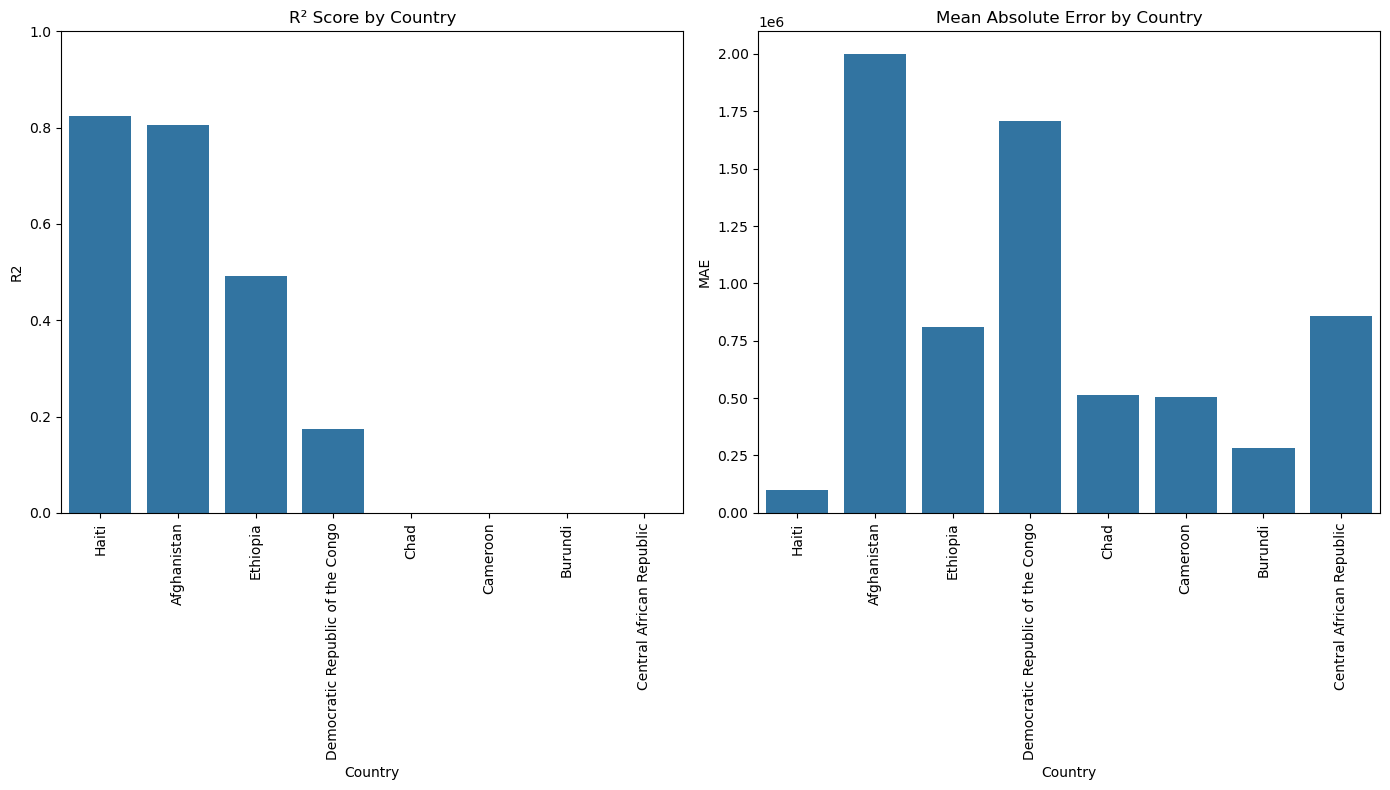

In [70]:
# Visualize performance metrics by country
plt.figure(figsize=(14, 8))

# Sort countries by R2 score
sorted_countries = performance_df.sort_values('R2', ascending=False)['Country'].tolist()

# Create bar chart for R2 scores
plt.subplot(1, 2, 1)
sns.barplot(x='Country', y='R2', data=performance_df, order=sorted_countries)
plt.title('R² Score by Country')
plt.xticks(rotation=90)
plt.ylim(0, 1)  # R2 is typically between 0 and 1

# Create bar chart for MAE
plt.subplot(1, 2, 2)
sns.barplot(x='Country', y='MAE', data=performance_df, order=sorted_countries)
plt.title('Mean Absolute Error by Country')
plt.xticks(rotation=90)

plt.tight_layout()
print("\nSaved performance comparison chart to 'country_performance_comparison.png'")

# Train country-specific models and analyze feature importance differences
print("\nAnalyzing feature importance by country...")

Analyzing feature importance for Afghanistan...
One-hot encoding 3 categorical columns
Filling 6 missing values in column 'start_month' with median
Filling 6 missing values in column 'end_year' with median
Filling 6 missing values in column 'end_month' with median
Filling 9 missing values in column 'total_affected' with median


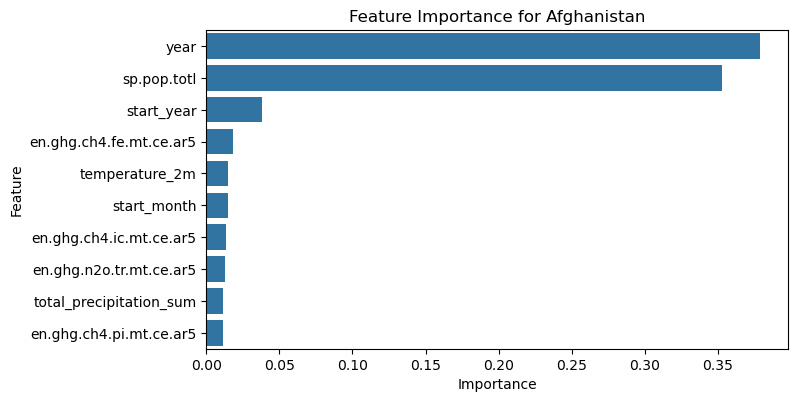

Analyzing feature importance for Antigua and Barbuda...
Insufficient data for Antigua and Barbuda - skipping feature importance analysis
Analyzing feature importance for Bahamas (the)...
Insufficient data for Bahamas (the) - skipping feature importance analysis
Analyzing feature importance for Benin...
Insufficient data for Benin - skipping feature importance analysis
Analyzing feature importance for Bolivia (Plurinational State of)...
Insufficient data for Bolivia (Plurinational State of) - skipping feature importance analysis
Analyzing feature importance for Burkina Faso...
Insufficient data for Burkina Faso - skipping feature importance analysis
Analyzing feature importance for Burundi...
One-hot encoding 3 categorical columns
Filling 57 missing values in column 'start_month' with median
Filling 57 missing values in column 'end_year' with median
Filling 57 missing values in column 'end_month' with median
Filling 58 missing values in column 'total_affected' with median


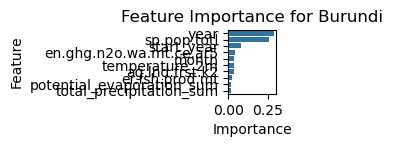

Analyzing feature importance for Cameroon...
One-hot encoding 3 categorical columns
Filling 22 missing values in column 'start_month' with median
Filling 20 missing values in column 'end_year' with median
Filling 20 missing values in column 'end_month' with median
Filling 20 missing values in column 'total_affected' with median


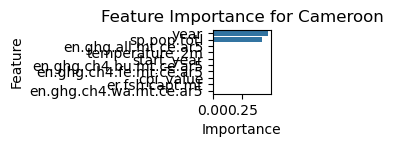

Analyzing feature importance for Central African Republic...
One-hot encoding 3 categorical columns
Filling 12 missing values in column 'start_month' with median
Filling 9 missing values in column 'end_year' with median
Filling 9 missing values in column 'end_month' with median
Filling 9 missing values in column 'total_affected' with median


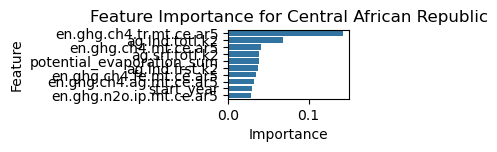

Analyzing feature importance for Chad...
One-hot encoding 3 categorical columns
Filling 9 missing values in column 'start_month' with median
Filling 9 missing values in column 'end_year' with median
Filling 9 missing values in column 'end_month' with median
Filling 9 missing values in column 'total_affected' with median


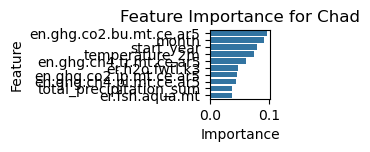

Analyzing feature importance for Democratic Republic of The Congo...
Insufficient data for Democratic Republic of The Congo - skipping feature importance analysis
Analyzing feature importance for Democratic Republic of the Congo...
One-hot encoding 3 categorical columns
Filling 31 missing values in column 'start_month' with median
Filling 17 missing values in column 'end_year' with median
Filling 17 missing values in column 'end_month' with median
Filling 24 missing values in column 'total_affected' with median
Filling 99 missing values in column 'sp.pop.totl' with median


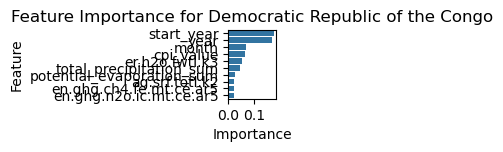

Analyzing feature importance for Djibouti...
Insufficient data for Djibouti - skipping feature importance analysis
Analyzing feature importance for Dominica...
Insufficient data for Dominica - skipping feature importance analysis
Analyzing feature importance for Ecuador...
Insufficient data for Ecuador - skipping feature importance analysis
Analyzing feature importance for El Salvador...
Insufficient data for El Salvador - skipping feature importance analysis
Analyzing feature importance for Ethiopia...
One-hot encoding 3 categorical columns
Filling 18 missing values in column 'start_month' with median
Filling 12 missing values in column 'end_year' with median
Filling 12 missing values in column 'end_month' with median
Filling 16 missing values in column 'total_affected' with median


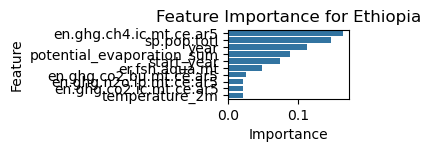

Analyzing feature importance for Fiji...
Insufficient data for Fiji - skipping feature importance analysis
Analyzing feature importance for Grenada...
Insufficient data for Grenada - skipping feature importance analysis
Analyzing feature importance for Guatemala...
Insufficient data for Guatemala - skipping feature importance analysis
Analyzing feature importance for Haiti...
One-hot encoding 3 categorical columns
Filling 19 missing values in column 'start_month' with median
Filling 17 missing values in column 'end_year' with median
Filling 17 missing values in column 'end_month' with median
Filling 21 missing values in column 'total_affected' with median


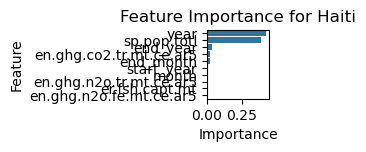

Analyzing feature importance for Honduras...
Insufficient data for Honduras - skipping feature importance analysis


In [60]:
# Function to train a country-specific model and get feature importance
def get_country_feature_importance(country_name, full_data, country_col, 
                                 target_col='internally_displaced_persons'):
    """
    Trains a country-specific model and returns feature importance
    
    Args:
        country_name: Name of the country to analyze
        full_data: Original dataframe with country column
        country_col: Name of the country column
        target_col: Name of the target column
    
    Returns:
        DataFrame with feature importance for this country
    """
    # Get data for this country
    country_df = full_data[full_data[country_col] == country_name]
    
    if len(country_df) < 10:
        print(f"Insufficient data for {country_name} - skipping feature importance analysis")
        return None
    
    # Preprocess the country data
    country_X, country_y, _ = preprocess_data(country_df, target_col=target_col, country_col=country_col)
    
    # Ensure the country data has the same features as the main model
    missing_cols = set(X.columns) - set(country_X.columns)
    for col in missing_cols:
        country_X[col] = 0
    
    # Select only the columns used in the main model and in the same order
    country_X = country_X[X.columns]
    
    # Train a country-specific model
    country_model = RandomForestRegressor(n_estimators=100, random_state=42)
    country_model.fit(country_X, country_y)
    
    # Get feature importance
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': country_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return importance

# Create feature importance visualization for each country
plt.figure(figsize=(20, 15))
country_feature_importances = {}
for country in countries_to_evaluate:
    print(f"Analyzing feature importance for {country}...")
    importance = get_country_feature_importance(country, df, country_column)
    if importance is not None:
        country_feature_importances[country] = importance
        # Plot feature importance
        plt.subplot(4, 3, len(country_feature_importances))
        sns.barplot(x='Importance', y='Feature', data=importance.head(10))
        plt.title(f'Feature Importance for {country}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

Insufficient data for Burkina Faso - skipping feature importance analysis
One-hot encoding 3 categorical columns
Filling 57 missing values in column 'start_month' with median
Filling 57 missing values in column 'end_year' with median
Filling 57 missing values in column 'end_month' with median
Filling 58 missing values in column 'total_affected' with median
One-hot encoding 3 categorical columns
Filling 22 missing values in column 'start_month' with median
Filling 20 missing values in column 'end_year' with median
Filling 20 missing values in column 'end_month' with median
Filling 20 missing values in column 'total_affected' with median
One-hot encoding 3 categorical columns
Filling 9 missing values in column 'start_month' with median
Filling 9 missing values in column 'end_year' with median
Filling 9 missing values in column 'end_month' with median
Filling 9 missing values in column 'total_affected' with median
Insufficient data for Grenada - skipping feature importance analysis
One-ho

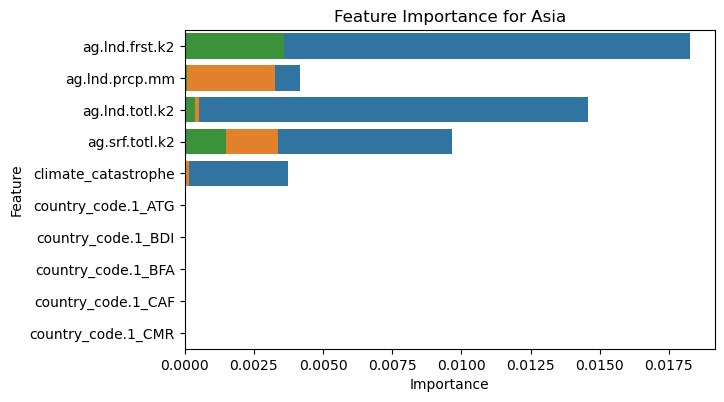

In [68]:
# now group the countries which have data by region
# and plot the feature importance for each region
# For simplicity, let's assume we have a predefined mapping of countries to regions
region_mapping = {
    'Africa': ['Burkina Faso', 'Burundi', 'Cameroon', 'Chad', 'Grenada', 'Ethiopia', 'Central African Republic', 'Democratic Republic of The Congo', 'Djibouti'],
    'Americas': ['Antigua and Barbuda', 'Bahamas (the)', 'Dominican Republic', 'Haiti', 'Guatemala'],
    'Asia': ['Afghanistan', 'Ecuador', 'El Salvador'],
}
# Create a new DataFrame to hold the region-wise feature importance for Asia
region_feature_importance = pd.DataFrame()
for region, countries in region_mapping.items():
    # Get feature importance for each country in the region
    region_importance = pd.DataFrame()
    for country in countries:
        importance = get_country_feature_importance(country, df, country_column)
        if importance is not None:
            region_importance = pd.concat([region_importance, importance], axis=0)
    
    # Group by feature and average the importance
    region_importance = region_importance.groupby('Feature').mean().reset_index()
    region_importance['Region'] = region
    region_feature_importance = pd.concat([region_feature_importance, region_importance], axis=0)
# Plot the region-wise feature importance
plt.figure(figsize=(20, 15))
for region in region_feature_importance['Region'].unique():
    plt.subplot(4, 3, len(region_feature_importance['Region'].unique()))
    sns.barplot(x='Importance', y='Feature', data=region_feature_importance[region_feature_importance['Region'] == region].head(10))
    plt.title(f'Feature Importance for {region}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
plt.show()

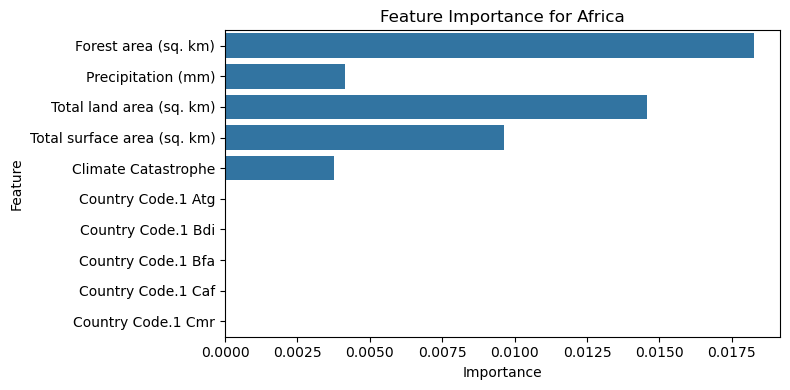

In [77]:
africa_importance = region_feature_importance[region_feature_importance['Region'] == 'Africa']
# rename the features to be more readable
africa_importance['Feature'] = africa_importance['Feature'].str.replace('_', ' ').str.title()
africa_importance['Feature'] = africa_importance['Feature'].str.replace('Gdp', 'GDP').str.replace('Population', 'Population').str.replace('Urban', 'Urban').str.replace('Rural', 'Rural')
africa_importance['Feature'] = africa_importance['Feature'].str.replace('Climate', 'Climate').str.replace('Displaced', 'Displaced').str.replace('Conflict', 'Conflict').str.replace('Natural', 'Natural').str.replace('Disasters', 'Disasters').str.replace('Floods', 'Floods').str.replace('Droughts', 'Droughts').str.replace('Earthquakes', 'Earthquakes').str.replace('Landslides', 'Landslides').str.replace('Storms', 'Storms').str.replace('Tsunamis', 'Tsunamis')
africa_importance['Feature'] = africa_importance['Feature'].replace({
    'country_name_Antigua and Barbuda': 'Antigua and Barbuda',
    'country_name_Bahamas (the)': 'Bahamas',
    'country_name_Dominican Republic': 'Dominican Republic',
    'country_name_Haiti': 'Haiti',
    'country_name_Guatemala': 'Guatemala',
    'ag.lnd.frst.k2': 'Forest area (sq. km)',
    'ag.lnd.prcp.mm': 'Precipitation (mm)',
    'ag.lnd.totl.k2': 'Total land area (sq. km)',
    'ag.srf.totl.k2': 'Total surface area (sq. km)',
    'country_code.1_Atg': 'Antigua and Barbuda',
    'country_code.1_Bdi': 'Burundi',
    'country_code.1_Cma': 'Cameroon',
    'country_code.1_COD': 'Democratic Republic of the Congo',
    'country_code.1_Bfa': 'Burkina Faso',
    'country_code.1_Caf': 'Central African Republic',
    'Ag.Lnd.Frst.K2': 'Forest area (sq. km)',
    'Ag.Lnd.Prcp.Mm': 'Precipitation (mm)',
    'Ag.Lnd.Totl.K2': 'Total land area (sq. km)',
    'Ag.Srf.Totl.K2': 'Total surface area (sq. km)',
})
# plot for Africa
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=africa_importance.head(10))
plt.title(f'Feature Importance for Africa')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

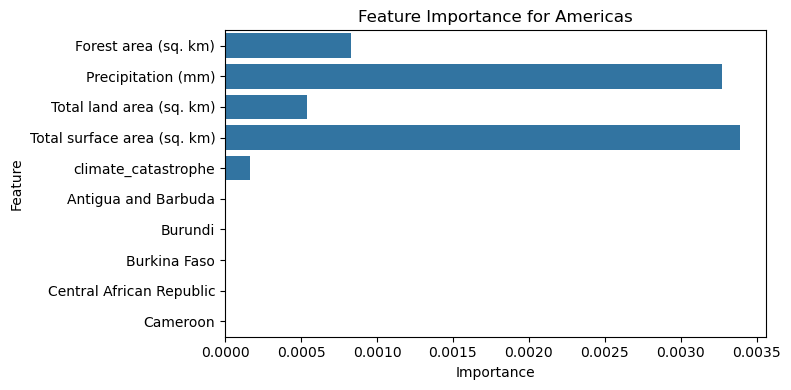

In [74]:
americas_importance = region_feature_importance[region_feature_importance['Region'] == 'Americas']
# rename the features to be more readable in the plot
americas_importance['Feature'] = americas_importance['Feature'].replace({
    'country_name_Antigua and Barbuda': 'Antigua and Barbuda',
    'country_name_Bahamas (the)': 'Bahamas',
    'country_name_Dominican Republic': 'Dominican Republic',
    'country_name_Haiti': 'Haiti',
    'country_name_Guatemala': 'Guatemala',
    'ag.lnd.frst.k2': 'Forest area (sq. km)',
    'ag.lnd.prcp.mm': 'Precipitation (mm)',
    'ag.lnd.totl.k2': 'Total land area (sq. km)',
    'ag.srf.totl.k2': 'Total surface area (sq. km)',
    'country_code.1_ATG': 'Antigua and Barbuda',
    'country_code.1_BDI': 'Burundi',
    'country_code.1_CMR': 'Cameroon',
    'country_code.1_COD': 'Democratic Republic of the Congo',
    'country_code.1_BFA': 'Burkina Faso',
    'country_code.1_CAF': 'Central African Republic',
})
# plot feature importnace for americas
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=americas_importance.head(10))
plt.title(f'Feature Importance for Americas')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
#